In [1]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import scipy.stats as stats

plt.rcParams['font.sans-serif'] = ['Hiragino Sans', 'Yu Gothic', 'IPAexGothic', 'Noto Sans CJK JP']
plt.rcParams['axes.unicode_minus'] = False

In [2]:
#データを整理
df23_24 = pd.read_csv('/Users/nakamurawataru/Documents/学校/研究室/SDSC/03.バスケ/6月送付分/【2025年度】プレイバイプレイ_23-24シーズン.csv')
df24_25 = pd.read_csv('/Users/nakamurawataru/Documents/学校/研究室/SDSC/03.バスケ/6月送付分/【2025年度】プレイバイプレイ_24-25シーズン.csv')
df_box = pd.read_csv('/Users/nakamurawataru/Documents/学校/研究室/SDSC/03.バスケ/6月送付分/【2025年度】ボックススコア.csv')
df_game = pd.read_csv('/Users/nakamurawataru/Documents/学校/研究室/SDSC/03.バスケ/6月送付分/【2025年度】試合データ.csv')
df_team = pd.read_csv('/Users/nakamurawataru/Documents/学校/研究室/SDSC/03.バスケ/6月送付分/【2025年度】チームマスタ.csv')
df_cluster = pd.read_csv('/Users/nakamurawataru/Documents/学校/研究室/SDSC/analysis/B1_clusters_2024-25.csv', header=1)
df_players = pd.read_csv('/Users/nakamurawataru/Documents/学校/研究室/SDSC/03.バスケ/6月送付分/【2025年度】選手マスタ.csv')


df_box['プレイタイム_秒'] = (
    df_box['プレイタイム']
    .astype(str)                               # 念のため文字列化
    .str.replace('：', ':', regex=False)       # 全角コロン対策
    .apply(lambda x: int(x.split(':')[0]) * 60 + int(x.split(':')[1]) if ':' in x else 0)
)

#リーグの試合IDを抽出
cupID = [500, 507]
df_gameID_cupID = df_game[df_game['カップID'].isin(cupID)]
df_gameID_cupID = df_gameID_cupID['試合ID'].unique()

cupID24_25 = [507]
df_gameID_cupID24_25 = df_game[df_game['カップID'].isin(cupID24_25)]
df_gameID_cupID24_25 = df_gameID_cupID24_25['試合ID'].unique()

#試合IDからデータを抽出
df23_24 = df23_24[df23_24['試合ID'].isin(df_gameID_cupID24_25)]
df24_25 = df24_25[df24_25['試合ID'].isin(df_gameID_cupID24_25)]
df_game = df_game[df_game['試合ID'].isin(df_gameID_cupID24_25)]
df_box24_25 = df_box[df_box['試合ID'].isin(df_gameID_cupID24_25)]

# 試合ID、チームIDごとにデータを整理
df_box_gameid = df_box.drop(columns=['ホームアウェイ','選手ID','背番号','選手名','スターティングフラグ','プレイタイム'])
df_box_gameid_sum = df_box_gameid[df_box_gameid['ピリオド区分'] == 18].groupby(['試合ID','チームID']).sum(numeric_only=True).reset_index()

# 試合IDごとに勝敗を割り当て
# 1. 試合IDごとに得点の最大値を取得
max_scores = df_box_gameid_sum.groupby('試合ID')['得点'].transform('max')
# 2. 自チームの得点が最大なら1（勝ち）、そうでなければ0（負け）
df_box_gameid_sum['勝敗'] = (df_box_gameid_sum['得点'] == max_scores).astype(int)

# 試合データから失点列を作成（より効率的）
df_game_long = pd.concat([
    df_game[['試合ID', 'ホームチームID', 'アウェイ得点']].rename(
        columns={'ホームチームID': 'チームID', 'アウェイ得点': '失点'}
    ),
    df_game[['試合ID', 'アウェイチームID', 'ホーム得点']].rename(
        columns={'アウェイチームID': 'チームID', 'ホーム得点': '失点'}
    )
], ignore_index=True)

# df_box_gameid_sum に失点を結合
df_box_gameid_sum = df_box_gameid_sum.merge(
    df_game_long[['試合ID', 'チームID', '失点']],
    on=['試合ID', 'チームID'],
    how='left'
)

# 安全に成功率を計算するヘルパー
def safe_rate(df, num_col, den_col, out_col, fillna=0):
    if num_col not in df.columns or den_col not in df.columns:
        print(f"警告: 列がありません: {num_col} または {den_col}")
        return
    # 数値化（非数値は NaN）
    df[num_col] = pd.to_numeric(df[num_col], errors='coerce')
    df[den_col] = pd.to_numeric(df[den_col], errors='coerce')
    # 0 を NaN にしてゼロ除算を回避
    denom = df[den_col].replace({0: np.nan})
    # 計算（結果を float に強制）
    df[out_col] = (df[num_col] / denom).astype(float)
    # 数値化の再適用（万が一の非数を排除）
    df[out_col] = pd.to_numeric(df[out_col], errors='coerce')
    # 現実的な範囲に収める（負や 1 より大きい値が出た場合にクリップ）
    df[out_col] = df[out_col].clip(lower=0.0, upper=1.0)
    # オプションで NaN を置換
    if fillna is not None:
        df[out_col] = df[out_col].fillna(fillna)

# 成功率列を安全に作成
safe_rate(df_box_gameid_sum, '2P成功', '2P試投', '2P成功率')
safe_rate(df_box_gameid_sum, '3P成功', '3P試投', '3P成功率')
safe_rate(df_box_gameid_sum, 'フリースロー成功', 'フリースロー試投', 'フリースロー成功率')

mask = df_box_gameid_sum['試合ID'].isin(df_gameID_cupID24_25)
df_box_gameid_sum = df_box_gameid_sum.loc[mask].copy()

df_box24_25_gameid_sum = df_box_gameid_sum[df_box_gameid_sum['試合ID'].isin(df_gameID_cupID24_25)]

# ポジション抽出（大文字化して単語境界で SF または SG をマッチ）
df_sf_sg = df_players[df_players['ポジション'].astype(str).str.upper().str.contains(r'\b(?:SF|SG)\b', na=False)]

# 選手ID を重複除去してリスト化（必要なら文字列化）
ids = df_sf_sg['選手ID'].dropna().unique().tolist()

# df_box24_25 の選手ID 列と型が異なる可能性がある場合は同型化してから isin
df_sf_sg_player = df_box24_25[df_box24_25['選手ID'].isin(ids)]
df_sf_sg_player_nation = df_players[df_players['選手ID'].isin(ids)]

In [3]:
df_sf_sg_player_nation

,カップID,チームID,選手ID,背番号,選手名,ポジション,国籍,生年月日,身長,体重,在籍フラグ
1,500,692,22401,6,岡田 泰希,PG/SG,JAPAN,19990728,176,76,1
2,500,692,10263,7,澤邉 圭太,SG,JAPAN,19950305,185,87,1
4,500,692,33036,9,ヤン ジェミン,SF,"KOREA, REPUBLIC OF",19990622,201,93,1
5,500,692,15756,13,阿部 諒,SG,JAPAN,19950504,184,82,1
8,500,692,5100000035,21,渡部 琉,SF,JAPAN,20001003,193,86,1
...,...,...,...,...,...,...,...,...,...,...,...
1625,513,2891,30468,12,西野 曜,SF,JAPAN,19980727,199,94,1
1626,513,2891,5100000066,14,木村 圭吾,SG,JAPAN,20001108,188,82,1
1627,513,2891,9329,16,渡辺 竜之佑,PG/SG,JAPAN,19940824,189,90,1
1629,513,2891,10844,21,満田 丈太郎,SG/SF,JAPAN,19940418,188,83,1


In [4]:
# SF,SGのチーム別の平均リバウンド数を計算
df_calc = df_sf_sg_player.copy()

# プレイタイム秒が無ければプレイタイム(mm:ss)から変換
if 'プレイタイム_秒' not in df_calc.columns or df_calc['プレイタイム_秒'].isna().any():
    if 'プレイタイム' in df_calc.columns:
        df_calc.loc[:, 'プレイタイム_秒'] = (
            df_calc['プレイタイム']
            .astype(str)
            .str.replace('：', ':', regex=False)
            .apply(lambda x: int(x.split(':')[0]) * 60 + int(x.split(':')[1]) if ':' in x and all(p.isdigit() for p in x.split(':')) else np.nan)
        )
    else:
        df_calc.loc[:, 'プレイタイム_秒'] = np.nan

# 数値化・欠損処理（元 DF はそのまま）
df_calc.loc[:, 'プレイタイム_秒'] = pd.to_numeric(df_calc['プレイタイム_秒'], errors='coerce')
df_calc.loc[:, 'ディフェンスリバウンド'] = pd.to_numeric(df_calc.get('ディフェンスリバウンド', 0), errors='coerce').fillna(0)

# 選手ごとに合計（チームID と選手ID・選手名を残す）
agg = df_calc.groupby(['チームID', '選手ID', '選手名'], dropna=False, as_index=False).agg(
    total_DREB=('ディフェンスリバウンド', 'sum'),
    total_playtime_sec=('プレイタイム_秒', 'sum'),
    appearances=('試合ID', 'nunique')  # 任意：出場試合数
)

# ゼロ・負のプレイタイムを NaN にしてゼロ除算回避
agg.loc[agg['total_playtime_sec'] <= 0, 'total_playtime_sec'] = np.nan

# 40分換算（チームID を保持したまま）
agg.loc[:, 'DREB_per_40'] = agg['total_DREB'] / agg['total_playtime_sec'] * 60 * 40

# チーム単位の集計（正しい 40分換算を計算）
team_stats = agg.groupby('チームID', as_index=False).agg(
    team_total_DREB=('total_DREB', 'sum'),
    team_total_playtime_sec=('total_playtime_sec', 'sum'),
    player_count=('選手ID', 'nunique'),
    mean_player_DREB_per_40=('DREB_per_40', 'mean')  # 参考値（選手の平均）
)

# 安全化してチーム単位の 40分換算を計算
team_stats.loc[team_stats['team_total_playtime_sec'] <= 0, 'team_total_playtime_sec'] = np.nan
team_stats['team_DREB_per_40'] = team_stats['team_total_DREB'] / team_stats['team_total_playtime_sec'] * 60 * 40

# df_team を参照してチーム名を追加（存在しない場合は None）
if 'df_team' in globals():
    team_stats = team_stats.merge(df_team[['チームID', 'チーム名']].drop_duplicates(), on='チームID', how='left')
    team_stats['チーム名'] = team_stats['チーム名'].astype(str).str.strip()
else:
    team_stats['チーム名'] = None

# 表示（チーム名を先頭に）
cols = ['チームID', 'チーム名'] + [c for c in team_stats.columns if c not in ('チームID', 'チーム名')]
display(team_stats[cols].sort_values('team_DREB_per_40', ascending=False).reset_index(drop=True))

,チームID,チーム名,team_total_DREB,team_total_playtime_sec,player_count,mean_player_DREB_per_40,team_DREB_per_40
0,704,千葉ジェッツ,1776,877402.0,9,3.604016,4.857978
1,692,仙台89ERS,1328,668922.0,10,2.877231,4.764681
2,697,三遠ネオフェニックス,1366,747965.0,7,3.384580,4.383093
3,701,琉球ゴールデンキングス,1556,872546.0,8,3.952157,4.279889
4,721,広島ドラゴンフライズ,1162,670156.0,8,3.740666,4.161419
5,729,名古屋ダイヤモンドドルフィンズ,1420,843947.0,10,2.978036,4.038168
6,712,茨城ロボッツ,1220,729745.0,7,3.178578,4.012360
7,717,ファイティングイーグルス名古屋,1332,820169.0,8,3.413277,3.897733
8,699,京都ハンナリーズ,1688,1057282.0,10,3.550139,3.831712
9,703,宇都宮ブレックス,1068,675767.0,7,4.383079,3.793023


In [5]:
filtered_team_stats = team_stats[['チームID', 'チーム名', 'mean_player_DREB_per_40']]

list_cluster0 = df_cluster[df_cluster['Cluster']==0]['Club'].tolist()
list_cluster1 = df_cluster[df_cluster['Cluster']==1]['Club'].tolist()
list_cluster2 = df_cluster[df_cluster['Cluster']==2]['Club'].tolist()

filtered_team_stats = filtered_team_stats[filtered_team_stats['チーム名'].isin(list_cluster0 + ['越谷アルファーズ'])]
filtered_team_stats = filtered_team_stats[['チーム名','mean_player_DREB_per_40']]
display(filtered_team_stats.sort_values('mean_player_DREB_per_40', ascending=False).reset_index(drop=True))

filtered_team_stats.to_csv('filtered_team_stats.csv', index=False, encoding='utf-8-sig')

,チーム名,mean_player_DREB_per_40
0,宇都宮ブレックス,4.383079
1,琉球ゴールデンキングス,3.952157
2,シーホース三河,3.655143
3,千葉ジェッツ,3.604016
4,京都ハンナリーズ,3.550139
5,三遠ネオフェニックス,3.384580
6,アルバルク東京,3.300652
7,島根スサノオマジック,3.073437
8,名古屋ダイヤモンドドルフィンズ,2.978036
9,サンロッカーズ渋谷,2.701754


In [6]:
#　SG,SFのランキングを作成
# 元の df_box24_25 は変更しない（copy を使う）
df_calc = df_sf_sg_player.copy()

# プレイタイム秒が無ければプレイタイム(mm:ss)から変換
if 'プレイタイム_秒' not in df_calc.columns or df_calc['プレイタイム_秒'].isna().any():
    if 'プレイタイム' in df_calc.columns:
        df_calc.loc[:, 'プレイタイム_秒'] = (
            df_calc['プレイタイム']
            .astype(str)
            .str.replace('：', ':', regex=False)
            .apply(lambda x: int(x.split(':')[0]) * 60 + int(x.split(':')[1]) if ':' in x and all(p.isdigit() for p in x.split(':')) else np.nan)
        )
    else:
        df_calc.loc[:, 'プレイタイム_秒'] = np.nan

# 数値化・欠損処理（元 DF はそのまま）
df_calc.loc[:, 'プレイタイム_秒'] = pd.to_numeric(df_calc['プレイタイム_秒'], errors='coerce')
df_calc.loc[:, 'ディフェンスリバウンド'] = pd.to_numeric(df_calc.get('ディフェンスリバウンド', 0), errors='coerce').fillna(0)

# 選手ごとに合計（チームID と選手ID・選手名を残す）
agg = df_calc.groupby(['選手ID', '選手名'], dropna=False, as_index=False).agg(
    total_DREB=('ディフェンスリバウンド', 'sum'),
    total_playtime_sec=('プレイタイム_秒', 'sum'),
    appearances=('試合ID', 'nunique')  # 任意：出場試合数
)

# ゼロ・負のプレイタイムを NaN にしてゼロ除算回避
agg.loc[agg['total_playtime_sec'] <= 0, 'total_playtime_sec'] = np.nan

# 40分換算（チームID を保持したまま）
agg.loc[:, 'DREB_per_40'] = agg['total_DREB'] / agg['total_playtime_sec'] * 60 * 40

# チーム単位の集計（正しい 40分換算を計算）
players_stats = agg.groupby('選手ID', as_index=False).agg(
    player_total_DREB=('total_DREB', 'sum'),
    player_total_playtime_sec=('total_playtime_sec', 'sum'),
    mean_player_DREB_per_40=('DREB_per_40', 'mean')  # 参考値（選手の平均）
)

# 選手名を agg から取得（安全）
df_players_name_id = agg[['選手ID', '選手名']].drop_duplicates()
players_stats_filtered = players_stats.loc[
    players_stats['player_total_DREB'] > 100
].copy()

df_nation_unique = df_sf_sg_player_nation.drop_duplicates(subset='選手ID').copy()

# 選手名を追加してランキング作成
rank_df = players_stats_filtered.merge(df_players_name_id, on='選手ID', how='left').merge(df_nation_unique, on='選手ID', how='left')


rank_df = rank_df.sort_values('mean_player_DREB_per_40', ascending=False).reset_index(drop=True)
rank_df.insert(0, '順位', rank_df['mean_player_DREB_per_40'].rank(method='min', ascending=False).astype('Int64'))

display(rank_df)

# CSV 出力（必要に応じてパスを変更）
output_path = '/Users/nakamurawataru/Documents/学校/研究室/SDSC/analysis/rank_df_players_DREB_per_40.csv'
rank_df.to_csv(output_path, index=False, encoding='utf-8-sig')

rank_df_data = rank_df[['順位','mean_player_DREB_per_40','選手名_x','国籍']]

rank_df_data.to_csv('rank_df_data.csv', index=False, encoding='utf-8-sig')

,順位,選手ID,player_total_DREB,player_total_playtime_sec,mean_player_DREB_per_40,選手名_x,カップID,チームID,背番号,選手名_y,ポジション,国籍,生年月日,身長,体重,在籍フラグ
0,1,51000166,766,182617.0,10.066971,ヴィック・ロー,500,701,4,ヴィック・ロー,SF/PF,UNITED STATES,19951219,201,94,1
1,2,51000374,458,126995.0,8.655459,ルーク・メイ,500,712,32,ルーク・メイ,SF/PF,UNITED STATES,19970307,203,106,1
2,3,33097,596,171330.0,8.348801,ドウェイン・エバンス,500,721,13,ドウェイン・エバンス,SF/PF,UNITED STATES,19920124,201,104,1
3,4,51000313,498,153174.0,7.802891,ジェイク・レイマン,500,728,10,ジェイク・レイマン,SF/PF,UNITED STATES,19940307,206,95,1
4,5,51000416,606,188836.0,7.701921,デイビッド・ヌワバ,507,697,2,デイビッド・ヌワバ,SG/SF,UNITED STATES,19930114,196,99,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,85,32956,134,163304.0,1.969333,須藤 昂矢,500,694,30,須藤 昂矢,SG,JAPAN,19970515,186,93,1
85,86,8494,114,140914.0,1.941610,須田 侑太郎,500,729,11,須田 侑太郎,SG/SF,JAPAN,19920103,190,87,1
86,87,18845,140,177876.0,1.888956,中村 功平,500,712,13,中村 功平,PG/SG,JAPAN,19960916,181,76,1
87,88,8487,110,143251.0,1.842919,辻 直人,500,713,9,辻 直人,SG,JAPAN,19890908,185,82,1


In [7]:
rank_df()

TypeError: 'DataFrame' object is not callable

DREB のジニ係数（偏り度）: 0.426


,選手名,平均,分散,合計,試合数,チーム内割合
0,ジェフ・ギブス,8.831061,50.543141,2092.961413,237,0.168742
1,ティム・ソアレス,6.376464,31.236968,1881.056824,295,0.151658
2,カイ・ソット,11.459178,56.503764,1443.856447,126,0.116409
3,LJ・ピーク,4.294019,21.463943,1309.675653,305,0.105591
4,カイル・リチャードソン,6.129132,27.907292,931.628058,152,0.075111
5,榎田 拓真,3.907417,88.870508,695.520247,178,0.056075
6,井上 宗一郎,3.398119,43.563363,666.031297,196,0.053698
7,喜多川 修平,2.603893,27.261923,648.369300,249,0.052274
8,星川 堅信,3.073823,27.782796,593.247755,193,0.047830
9,松山 駿,2.370634,14.756237,566.581643,239,0.045680


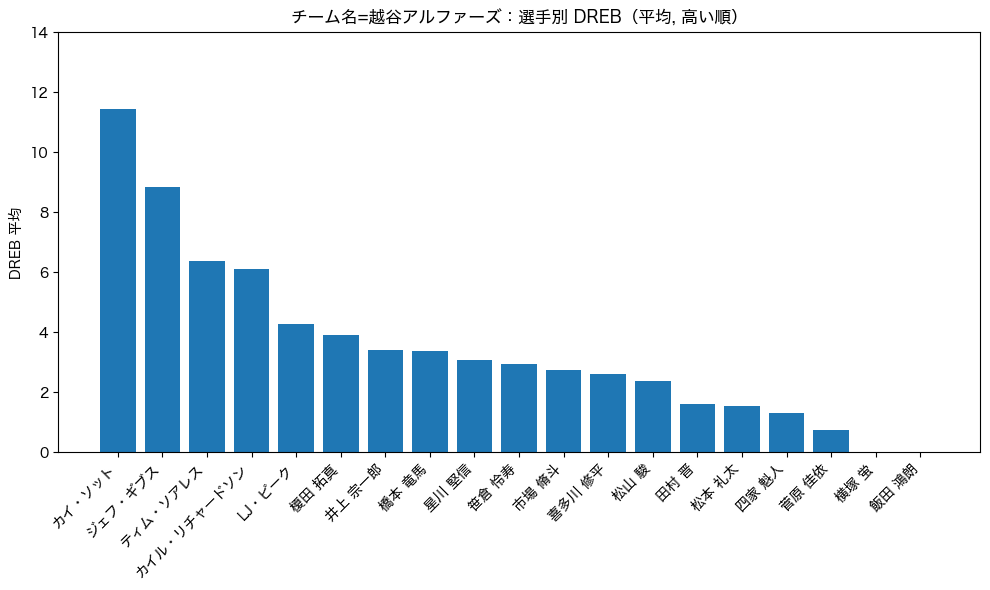

In [ ]:
# DRB 分析（改善版）
team_id = 745  # 必要に応じてチームIDを変更

# df_box が存在するか確認
if 'df_box' not in globals():
    raise RuntimeError("df_box が定義されていません。先にデータ読み込みセルを実行してください。")

# 選手別データ（プレイヤーレベル）を作成
df_players = df_box24_25.loc[df_box24_25['チームID'] == team_id].copy()

# 数値化・欠損処理
df_players['ディフェンスリバウンド'] = pd.to_numeric(df_players['ディフェンスリバウンド'], errors='coerce').fillna(0)

df_players['DREB_per_game'] = df_players['ディフェンスリバウンド'] / df_players['プレイタイム_秒'] * 60 * 40

# 選手ごとに集計
df_dreb_stats = (
    df_players.groupby('選手名')['DREB_per_game']
    .agg(['mean', 'var', 'sum', 'count'])
    .reset_index()
    .rename(columns={'mean': '平均', 'var': '分散', 'sum': '合計', 'count': '試合数'})
)

# チーム内合計が0の場合のガード
total_dreb = df_dreb_stats['合計'].sum()

# ジニ係数（安定化）
def gini(x):
    x = np.array(x, dtype=float)
    if x.size == 0:
        return np.nan
    s = x.sum()
    if s == 0:
        return 0.0
    x = np.sort(x)
    n = x.size
    index = np.arange(1, n + 1)
    return (2.0 * np.sum(index * x) / (n * s) - (n + 1) / n)

gini_dreb = gini(df_dreb_stats['平均'].values)
print(f"DREB のジニ係数（偏り度）: {gini_dreb:.3f}")

# 可視化：選手を合計でソートして表示
df_dreb_stats = df_dreb_stats.sort_values('合計', ascending=False).reset_index(drop=True)
df_dreb_stats['チーム内割合'] = df_dreb_stats['合計'] / total_dreb

team_name_series = df_team.loc[df_team['チームID'] == team_id, 'チーム名'] if 'df_team' in globals() else pd.Series(dtype=object)
team_name = team_name_series.iloc[0].strip() if not team_name_series.empty else None

display(df_dreb_stats)

df_plot = df_dreb_stats.sort_values('平均', ascending=False).reset_index(drop=True)
plt.figure(figsize=(10,6))
plt.bar(df_plot['選手名'], df_plot['平均'])
plt.title(f'チーム名={team_name}：選手別 DREB（平均, 高い順）')
plt.ylabel('DREB 平均')
plt.xticks(rotation=45, ha='right')


plt.ylim(0, 14)
plt.tight_layout()
plt.show()

DREB のジニ係数（偏り度）: 0.415


,選手名,平均,分散,合計,試合数,チーム内割合
0,グラント・ジェレット,7.895077,41.414643,2305.362386,292,0.176615
1,竹内 公輔,6.768316,46.354619,1854.518568,274,0.142076
2,D.J・ニュービル,6.178092,26.120397,1828.715113,296,0.140099
3,アイザック・フォトゥ,6.098460,39.638044,1774.651952,291,0.135957
4,ギャビン・エドワーズ,5.329909,33.058772,1092.631380,205,0.083707
5,鵤 誠司,3.174216,27.152089,863.386861,272,0.066145
6,比江島 慎,2.861809,15.101875,818.477415,286,0.062704
7,高島 紳司,2.671175,25.153203,737.244287,276,0.056481
8,遠藤 祐亮,2.219486,13.524229,654.748260,295,0.050161
9,小川 敦也,3.036391,28.636479,582.987043,192,0.044663


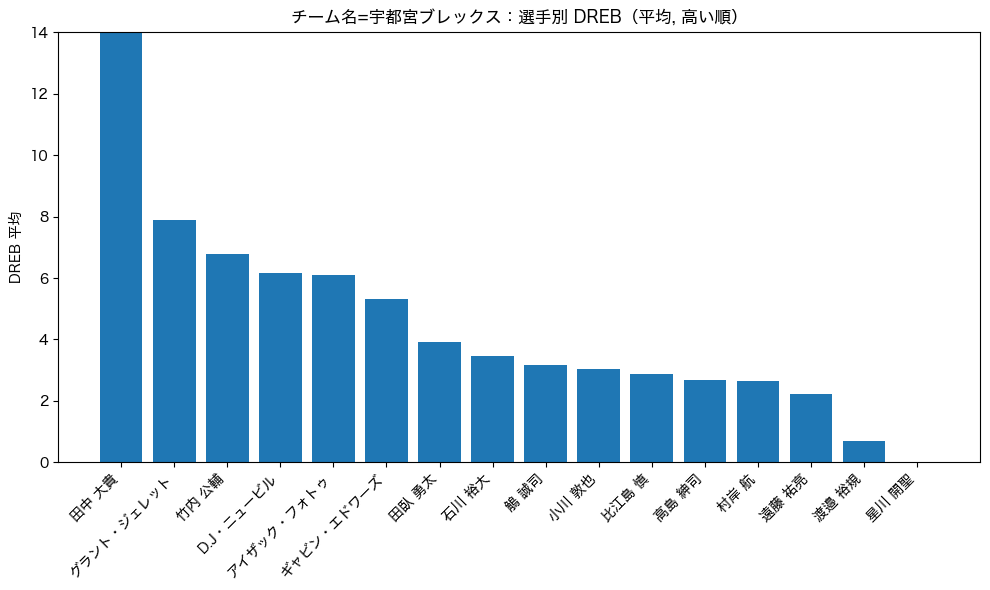

In [ ]:
# DRB 分析（改善版）
team_id = 703  # 必要に応じてチームIDを変更

# df_box が存在するか確認
if 'df_box' not in globals():
    raise RuntimeError("df_box が定義されていません。先にデータ読み込みセルを実行してください。")

# 選手別データ（プレイヤーレベル）を作成
df_players = df_box24_25.loc[df_box24_25['チームID'] == team_id].copy()

# 数値化・欠損処理
df_players['ディフェンスリバウンド'] = pd.to_numeric(df_players['ディフェンスリバウンド'], errors='coerce').fillna(0)

df_players['DREB_per_game'] = df_players['ディフェンスリバウンド'] / df_players['プレイタイム_秒'] * 60 * 40

# 選手ごとに集計
df_dreb_stats = (
    df_players.groupby('選手名')['DREB_per_game']
    .agg(['mean', 'var', 'sum', 'count'])
    .reset_index()
    .rename(columns={'mean': '平均', 'var': '分散', 'sum': '合計', 'count': '試合数'})
)

# チーム内合計が0の場合のガード
total_dreb = df_dreb_stats['合計'].sum()

# ジニ係数（安定化）
def gini(x):
    x = np.array(x, dtype=float)
    if x.size == 0:
        return np.nan
    s = x.sum()
    if s == 0:
        return 0.0
    x = np.sort(x)
    n = x.size
    index = np.arange(1, n + 1)
    return (2.0 * np.sum(index * x) / (n * s) - (n + 1) / n)

gini_dreb = gini(df_dreb_stats['平均'].values)
print(f"DREB のジニ係数（偏り度）: {gini_dreb:.3f}")

# 可視化：選手を合計でソートして表示
df_dreb_stats = df_dreb_stats.sort_values('合計', ascending=False).reset_index(drop=True)
df_dreb_stats['チーム内割合'] = df_dreb_stats['合計'] / total_dreb

display(df_dreb_stats)
team_name_series = df_team.loc[df_team['チームID'] == team_id, 'チーム名'] if 'df_team' in globals() else pd.Series(dtype=object)
team_name = team_name_series.iloc[0].strip() if not team_name_series.empty else None

df_plot = df_dreb_stats.sort_values('平均', ascending=False).reset_index(drop=True)
plt.figure(figsize=(10,6))
plt.bar(df_plot['選手名'], df_plot['平均'])
plt.title(f'チーム名={team_name}：選手別 DREB（平均, 高い順）')
plt.ylabel('DREB 平均')
plt.ylim(0, 14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

DREB のジニ係数（偏り度）: 0.369


,選手名,平均,分散,合計,試合数,チーム内割合
0,ジョン・ムーニー,11.116155,53.514194,2334.392563,210,0.188351
1,クリストファー・スミス,5.632245,34.941957,1684.041318,299,0.135877
2,ディー・ジェイ・ホグ,7.090924,36.061812,1659.276312,234,0.133879
3,渡邊 雄太,6.308340,34.051753,1078.726090,171,0.087037
4,原 修太,3.332877,20.879971,959.868435,288,0.077447
5,マイケル・オウ,6.116710,73.404512,850.222677,139,0.068600
6,金近 廉,2.909459,18.510527,808.829519,278,0.065260
7,ジョナサン・ウィリアムズ,7.289056,27.194766,648.726005,89,0.052342
8,富樫 勇樹,2.234761,12.715278,554.220819,248,0.044717
9,田代 直希,2.462173,17.518282,504.745395,205,0.040725


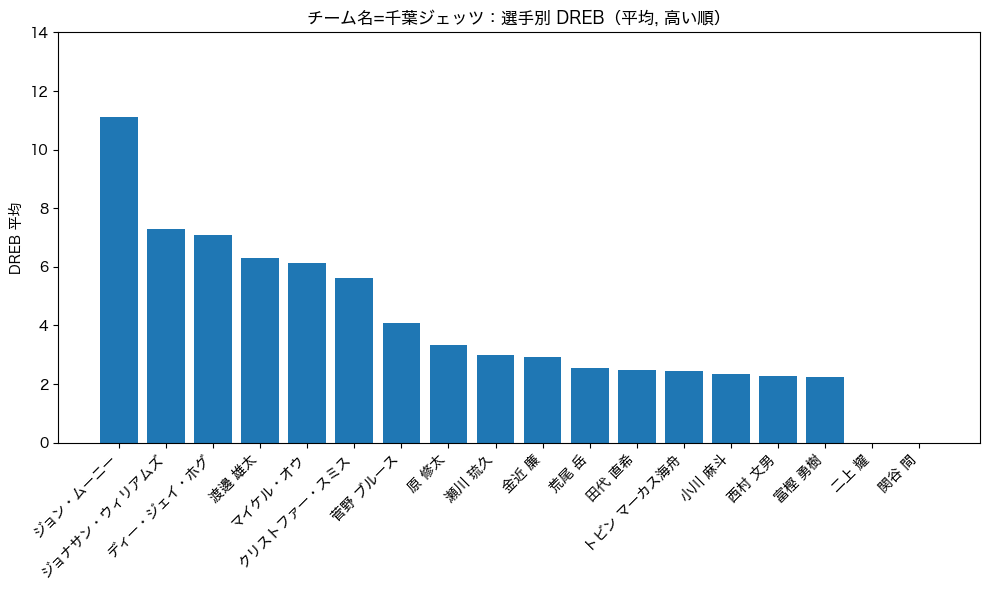

In [ ]:
# DRB 分析（改善版）
team_id = 704  # 必要に応じてチームIDを変更

# df_box が存在するか確認
if 'df_box' not in globals():
    raise RuntimeError("df_box が定義されていません。先にデータ読み込みセルを実行してください。")

# 選手別データ（プレイヤーレベル）を作成
df_players = df_box24_25.loc[df_box24_25['チームID'] == team_id].copy()

# 数値化・欠損処理
df_players['ディフェンスリバウンド'] = pd.to_numeric(df_players['ディフェンスリバウンド'], errors='coerce').fillna(0)

df_players['DREB_per_game'] = df_players['ディフェンスリバウンド'] / df_players['プレイタイム_秒'] * 60 * 40

# 選手ごとに集計
df_dreb_stats = (
    df_players.groupby('選手名')['DREB_per_game']
    .agg(['mean', 'var', 'sum', 'count'])
    .reset_index()
    .rename(columns={'mean': '平均', 'var': '分散', 'sum': '合計', 'count': '試合数'})
)

# チーム内合計が0の場合のガード
total_dreb = df_dreb_stats['合計'].sum()

# ジニ係数（安定化）
def gini(x):
    x = np.array(x, dtype=float)
    if x.size == 0:
        return np.nan
    s = x.sum()
    if s == 0:
        return 0.0
    x = np.sort(x)
    n = x.size
    index = np.arange(1, n + 1)
    return (2.0 * np.sum(index * x) / (n * s) - (n + 1) / n)

gini_dreb = gini(df_dreb_stats['平均'].values)
print(f"DREB のジニ係数（偏り度）: {gini_dreb:.3f}")

# 可視化：選手を合計でソートして表示
df_dreb_stats = df_dreb_stats.sort_values('合計', ascending=False).reset_index(drop=True)
df_dreb_stats['チーム内割合'] = df_dreb_stats['合計'] / total_dreb

display(df_dreb_stats)
team_name_series = df_team.loc[df_team['チームID'] == team_id, 'チーム名'] if 'df_team' in globals() else pd.Series(dtype=object)
team_name = team_name_series.iloc[0].strip() if not team_name_series.empty else None

df_plot = df_dreb_stats.sort_values('平均', ascending=False).reset_index(drop=True)
plt.figure(figsize=(10,6))
plt.bar(df_plot['選手名'], df_plot['平均'])
plt.title(f'チーム名={team_name}：選手別 DREB（平均, 高い順）')
plt.ylabel('DREB 平均')
plt.ylim(0, 14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

DREB のジニ係数（偏り度）: 0.266


,選手名,平均,分散,合計,試合数,チーム内割合
0,ライアン・ロシター,9.801363,46.466905,2960.011770,302,0.222471
1,セバスチャン・サイズ,6.183024,35.276360,1885.822287,305,0.141736
2,レオナルド・メインデル,5.274444,30.051366,1492.667556,283,0.112187
3,ザック・バランスキー,4.479618,46.355533,1164.700558,260,0.087538
4,安藤 周人,3.251909,23.779748,982.076641,302,0.073812
5,テーブス 海,3.035236,17.654045,813.443253,268,0.061138
6,スティーブ・ザック,6.944022,51.843471,798.562581,115,0.060019
7,アルトゥーラス・グダイティス,5.447356,37.090828,768.077183,141,0.057728
8,小酒部 泰暉,2.450730,15.570833,713.162475,291,0.053601
9,大倉 颯太,2.229603,22.540775,601.992772,270,0.045245


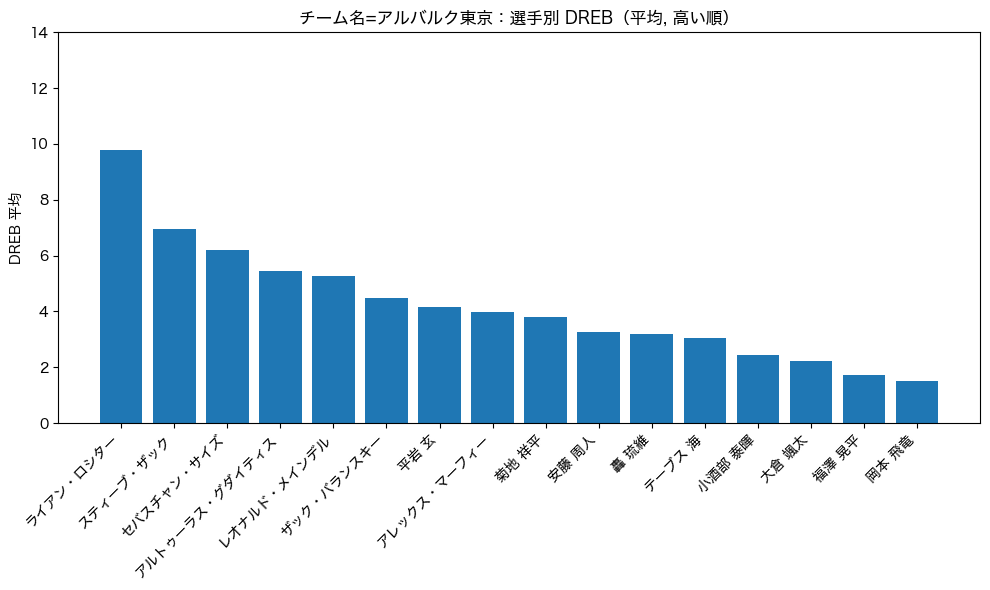

In [ ]:
# DRB 分析（改善版）
team_id = 706  # 必要に応じてチームIDを変更

# df_box が存在するか確認
if 'df_box' not in globals():
    raise RuntimeError("df_box が定義されていません。先にデータ読み込みセルを実行してください。")

# 選手別データ（プレイヤーレベル）を作成
df_players = df_box24_25.loc[df_box24_25['チームID'] == team_id].copy()

# 数値化・欠損処理
df_players['ディフェンスリバウンド'] = pd.to_numeric(df_players['ディフェンスリバウンド'], errors='coerce').fillna(0)

df_players['DREB_per_game'] = df_players['ディフェンスリバウンド'] / df_players['プレイタイム_秒'] * 60 * 40

# 選手ごとに集計
df_dreb_stats = (
    df_players.groupby('選手名')['DREB_per_game']
    .agg(['mean', 'var', 'sum', 'count'])
    .reset_index()
    .rename(columns={'mean': '平均', 'var': '分散', 'sum': '合計', 'count': '試合数'})
)

# チーム内合計が0の場合のガード
total_dreb = df_dreb_stats['合計'].sum()

# ジニ係数（安定化）
def gini(x):
    x = np.array(x, dtype=float)
    if x.size == 0:
        return np.nan
    s = x.sum()
    if s == 0:
        return 0.0
    x = np.sort(x)
    n = x.size
    index = np.arange(1, n + 1)
    return (2.0 * np.sum(index * x) / (n * s) - (n + 1) / n)

gini_dreb = gini(df_dreb_stats['平均'].values)
print(f"DREB のジニ係数（偏り度）: {gini_dreb:.3f}")

# 可視化：選手を合計でソートして表示
df_dreb_stats = df_dreb_stats.sort_values('合計', ascending=False).reset_index(drop=True)
df_dreb_stats['チーム内割合'] = df_dreb_stats['合計'] / total_dreb

display(df_dreb_stats)
team_name_series = df_team.loc[df_team['チームID'] == team_id, 'チーム名'] if 'df_team' in globals() else pd.Series(dtype=object)
team_name = team_name_series.iloc[0].strip() if not team_name_series.empty else None

df_plot = df_dreb_stats.sort_values('平均', ascending=False).reset_index(drop=True)
plt.figure(figsize=(10,6))
plt.bar(df_plot['選手名'], df_plot['平均'])
plt.title(f'チーム名={team_name}：選手別 DREB（平均, 高い順）')
plt.ylabel('DREB 平均')
plt.ylim(0, 14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

DREB のジニ係数（偏り度）: 0.448


,選手名,平均,分散,合計,試合数,チーム内割合
0,ジョシュ・ホーキンソン,7.961602,34.491008,2412.365437,303,0.231038
1,ケビン・ジョーンズ,5.721434,30.053683,1647.772969,288,0.157811
2,アンソニー・クレモンズ,4.744124,18.719531,1437.469591,303,0.137670
3,リード・トラビス,6.595246,41.383237,1352.025449,205,0.129487
4,トロイ・マーフィージュニア,3.691264,33.985801,996.641186,270,0.095451
5,ベンドラメ 礼生,2.767765,13.476144,824.794005,298,0.078993
6,田中 大貴,1.811164,7.917882,505.314864,279,0.048395
7,ハーパー・ジャン・ローレンス・ジュニア,3.033743,34.393041,409.555356,135,0.039224
8,阿部 諒,1.749763,21.993881,258.964892,148,0.024802
9,村越 圭佑,13.417900,673.965037,201.268499,15,0.019276


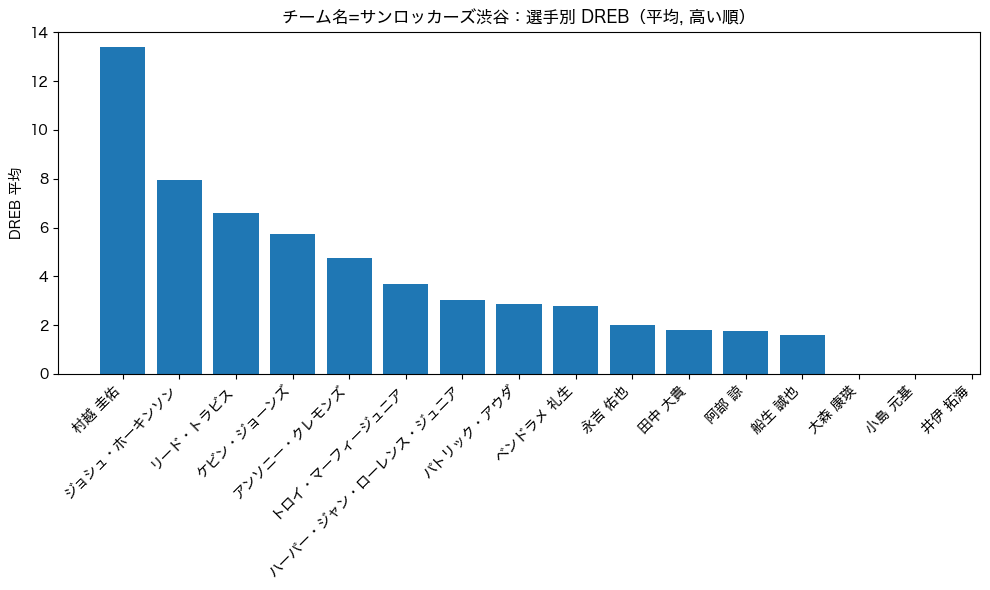

In [ ]:
# DRB 分析（改善版）
team_id = 726  # 必要に応じてチームIDを変更

# df_box が存在するか確認
if 'df_box' not in globals():
    raise RuntimeError("df_box が定義されていません。先にデータ読み込みセルを実行してください。")

# 選手別データ（プレイヤーレベル）を作成
df_players = df_box24_25.loc[df_box24_25['チームID'] == team_id].copy()

# 数値化・欠損処理
df_players['プレイタイム_秒'] = pd.to_numeric(df_players.get('プレイタイム_秒', df_players.get('プレイタイム', None)), errors='coerce')
df_players.loc[df_players['プレイタイム_秒'] <= 0, 'プレイタイム_秒'] = np.nan
df_players['ディフェンスリバウンド'] = pd.to_numeric(df_players['ディフェンスリバウンド'], errors='coerce').fillna(0)
df_players['DREB_per_game'] = df_players['ディフェンスリバウンド'] / df_players['プレイタイム_秒'] * 60 * 40

# 選手ごとに集計
df_dreb_stats = (
    df_players.groupby('選手名')['DREB_per_game']
    .agg(['mean', 'var', 'sum', 'count'])
    .reset_index()
    .rename(columns={'mean': '平均', 'var': '分散', 'sum': '合計', 'count': '試合数'})
)

# チーム内合計が0の場合のガード
total_dreb = df_dreb_stats['合計'].sum()

# ジニ係数（安定化）
def gini(x):
    x = np.asarray(x, dtype=float)
    x = x[~np.isnan(x)]
    if x.size == 0:
        return np.nan
    s = x.sum()
    if s == 0:
        return 0.0
    x = np.sort(x)
    n = x.size
    index = np.arange(1, n + 1)
    return (2.0 * np.sum(index * x) / (n * s) - (n + 1) / n)

gini_dreb = gini(df_dreb_stats['平均'].values)
print(f"DREB のジニ係数（偏り度）: {gini_dreb:.3f}")

# 可視化：選手を合計でソートして表示
df_dreb_stats = df_dreb_stats.sort_values('合計', ascending=False).reset_index(drop=True)
df_dreb_stats['チーム内割合'] = df_dreb_stats['合計'] / total_dreb

display(df_dreb_stats)
team_name_series = df_team.loc[df_team['チームID'] == team_id, 'チーム名'] if 'df_team' in globals() else pd.Series(dtype=object)
team_name = team_name_series.iloc[0].strip() if not team_name_series.empty else None

df_plot = df_dreb_stats.sort_values('平均', ascending=False).reset_index(drop=True)
plt.figure(figsize=(10,6))
plt.bar(df_plot['選手名'], df_plot['平均'])
plt.title(f'チーム名={team_name}：選手別 DREB（平均, 高い順）')
plt.ylabel('DREB 平均')
plt.ylim(0, 14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

DREB のジニ係数（偏り度）: 0.338


,選手名,平均,分散,合計,試合数,チーム内割合
0,ザック・オーガスト,9.218143,58.237429,2765.442771,300,0.222618
1,ジェイク・レイマン,7.637918,41.961477,1947.669021,255,0.156787
2,ダバンテ・ガードナー,6.047792,27.373125,1808.289730,299,0.145567
3,シェーファー アヴィ幸樹,4.958923,45.447729,1145.511173,231,0.092214
4,久保田 義章,3.246832,25.533281,905.866252,279,0.072922
5,西田 優大,2.898334,16.236812,799.940302,276,0.064395
6,角野 亮伍,2.629254,23.787198,767.742292,292,0.061803
7,長野 誠史,2.547376,24.721657,751.475805,295,0.060494
8,石井 講祐,2.927127,29.105029,541.518420,185,0.043592
9,須田 侑太郎,1.857716,11.402540,509.014088,274,0.040976


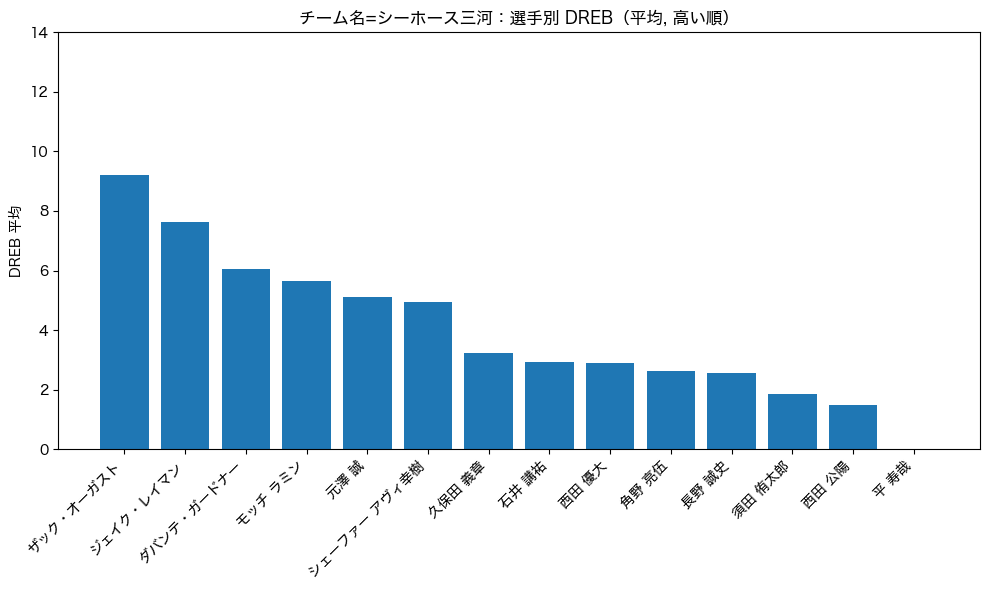

In [ ]:
# DRB 分析（改善版）
team_id = 728  # 必要に応じてチームIDを変更

# df_box が存在するか確認
if 'df_box' not in globals():
    raise RuntimeError("df_box が定義されていません。先にデータ読み込みセルを実行してください。")

# 選手別データ（プレイヤーレベル）を作成
df_players = df_box24_25.loc[df_box24_25['チームID'] == team_id].copy()

# 数値化・欠損処理
df_players['ディフェンスリバウンド'] = pd.to_numeric(df_players['ディフェンスリバウンド'], errors='coerce').fillna(0)

df_players['DREB_per_game'] = df_players['ディフェンスリバウンド'] / df_players['プレイタイム_秒'] * 60 * 40

# 選手ごとに集計
df_dreb_stats = (
    df_players.groupby('選手名')['DREB_per_game']
    .agg(['mean', 'var', 'sum', 'count'])
    .reset_index()
    .rename(columns={'mean': '平均', 'var': '分散', 'sum': '合計', 'count': '試合数'})
)

# チーム内合計が0の場合のガード
total_dreb = df_dreb_stats['合計'].sum()

# ジニ係数（安定化）
def gini(x):
    x = np.array(x, dtype=float)
    if x.size == 0:
        return np.nan
    s = x.sum()
    if s == 0:
        return 0.0
    x = np.sort(x)
    n = x.size
    index = np.arange(1, n + 1)
    return (2.0 * np.sum(index * x) / (n * s) - (n + 1) / n)

gini_dreb = gini(df_dreb_stats['平均'].values)
print(f"DREB のジニ係数（偏り度）: {gini_dreb:.3f}")

# 可視化：選手を合計でソートして表示
df_dreb_stats = df_dreb_stats.sort_values('合計', ascending=False).reset_index(drop=True)
df_dreb_stats['チーム内割合'] = df_dreb_stats['合計'] / total_dreb

display(df_dreb_stats)
team_name_series = df_team.loc[df_team['チームID'] == team_id, 'チーム名'] if 'df_team' in globals() else pd.Series(dtype=object)
team_name = team_name_series.iloc[0].strip() if not team_name_series.empty else None

df_plot = df_dreb_stats.sort_values('平均', ascending=False).reset_index(drop=True)
plt.figure(figsize=(10,6))
plt.bar(df_plot['選手名'], df_plot['平均'])
plt.title(f'チーム名={team_name}：選手別 DREB（平均, 高い順）')
plt.ylabel('DREB 平均')
plt.ylim(0, 14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

DREB のジニ係数（偏り度）: 0.264


,選手名,平均,分散,合計,試合数,チーム内割合
0,デイビッド・ヌワバ,7.679526,39.180098,2196.344369,286,0.174950
1,ヤンテ・メイテン,7.065340,35.815745,1950.033887,276,0.155330
2,デイビッド・ダジンスキー,6.041236,39.698195,1794.246956,297,0.142921
3,吉井 裕鷹,3.837088,25.271576,1001.479960,261,0.079773
4,大浦 颯太,3.132136,24.829686,920.848096,294,0.073350
5,兪 龍海,3.771900,59.346026,833.589929,221,0.066400
6,佐々木 隆成,2.836569,17.377835,825.441684,291,0.065751
7,ウィリアムス ニカ,3.595041,40.276946,823.264295,229,0.065577
8,湧川 颯斗,3.388135,29.868849,819.928629,242,0.065312
9,津屋 一球,2.795148,25.739685,816.183135,292,0.065013


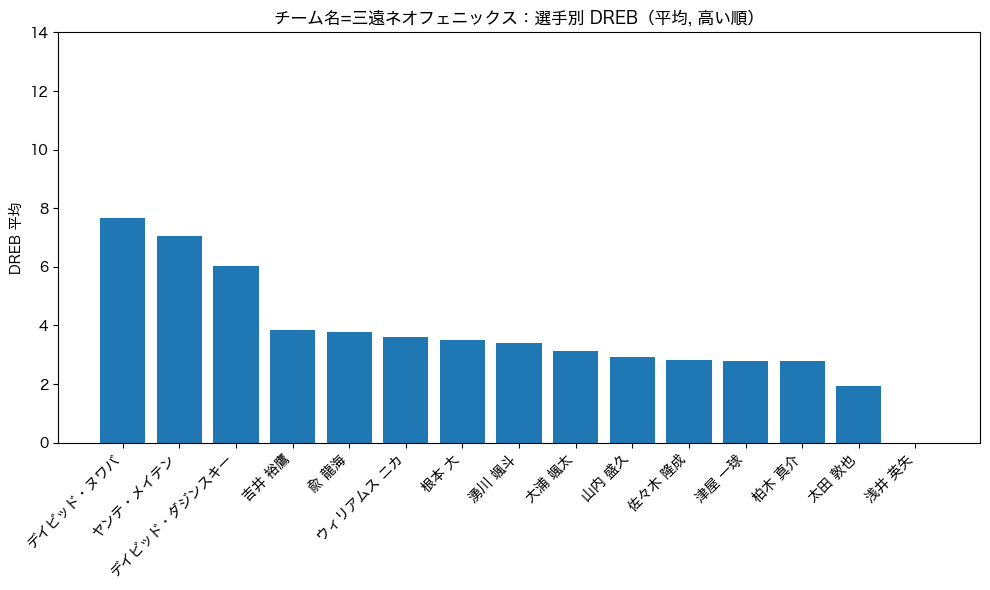

In [ ]:
# DRB 分析（改善版）
team_id = 697  # 必要に応じてチームIDを変更

# df_box が存在するか確認
if 'df_box' not in globals():
    raise RuntimeError("df_box が定義されていません。先にデータ読み込みセルを実行してください。")

# 選手別データ（プレイヤーレベル）を作成
df_players = df_box24_25.loc[df_box24_25['チームID'] == team_id].copy()

# 数値化・欠損処理
df_players['ディフェンスリバウンド'] = pd.to_numeric(df_players['ディフェンスリバウンド'], errors='coerce').fillna(0)

df_players['DREB_per_game'] = df_players['ディフェンスリバウンド'] / df_players['プレイタイム_秒'] * 60 * 40

# 選手ごとに集計
df_dreb_stats = (
    df_players.groupby('選手名')['DREB_per_game']
    .agg(['mean', 'var', 'sum', 'count'])
    .reset_index()
    .rename(columns={'mean': '平均', 'var': '分散', 'sum': '合計', 'count': '試合数'})
)

# チーム内合計が0の場合のガード
total_dreb = df_dreb_stats['合計'].sum()

# ジニ係数（安定化）
def gini(x):
    x = np.array(x, dtype=float)
    if x.size == 0:
        return np.nan
    s = x.sum()
    if s == 0:
        return 0.0
    x = np.sort(x)
    n = x.size
    index = np.arange(1, n + 1)
    return (2.0 * np.sum(index * x) / (n * s) - (n + 1) / n)

gini_dreb = gini(df_dreb_stats['平均'].values)
print(f"DREB のジニ係数（偏り度）: {gini_dreb:.3f}")

# 可視化：選手を合計でソートして表示
df_dreb_stats = df_dreb_stats.sort_values('合計', ascending=False).reset_index(drop=True)
df_dreb_stats['チーム内割合'] = df_dreb_stats['合計'] / total_dreb

display(df_dreb_stats)
team_name_series = df_team.loc[df_team['チームID'] == team_id, 'チーム名'] if 'df_team' in globals() else pd.Series(dtype=object)
team_name = team_name_series.iloc[0].strip() if not team_name_series.empty else None

df_plot = df_dreb_stats.sort_values('平均', ascending=False).reset_index(drop=True)
plt.figure(figsize=(10,6))
plt.bar(df_plot['選手名'], df_plot['平均'])
plt.title(f'チーム名={team_name}：選手別 DREB（平均, 高い順）')
plt.ylabel('DREB 平均')
plt.ylim(0, 14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

DREB のジニ係数（偏り度）: 0.303


,選手名,平均,分散,合計,試合数,チーム内割合
0,チャールズ・ジャクソン,9.237390,48.443071,2734.267520,296,0.219980
1,アンジェロ・カロイアロ,7.326224,28.714729,2212.519736,302,0.178004
2,ジョーダン・ヒース,7.423351,50.989212,2137.925188,288,0.172003
3,前田 悟,3.510144,22.452335,1017.941703,290,0.081897
4,岡田 侑大,2.610966,13.642385,738.903370,283,0.059447
5,小西 聖也,3.416604,53.334036,690.154058,202,0.055525
6,古川 孝敏,2.486014,15.736892,631.447502,254,0.050802
7,ラシード ファラーズ,4.988484,74.933484,618.572043,124,0.049766
8,川嶋 勇人,2.152569,12.821506,583.346293,271,0.046932
9,澁田 怜音,1.694781,52.058878,396.578775,234,0.031906


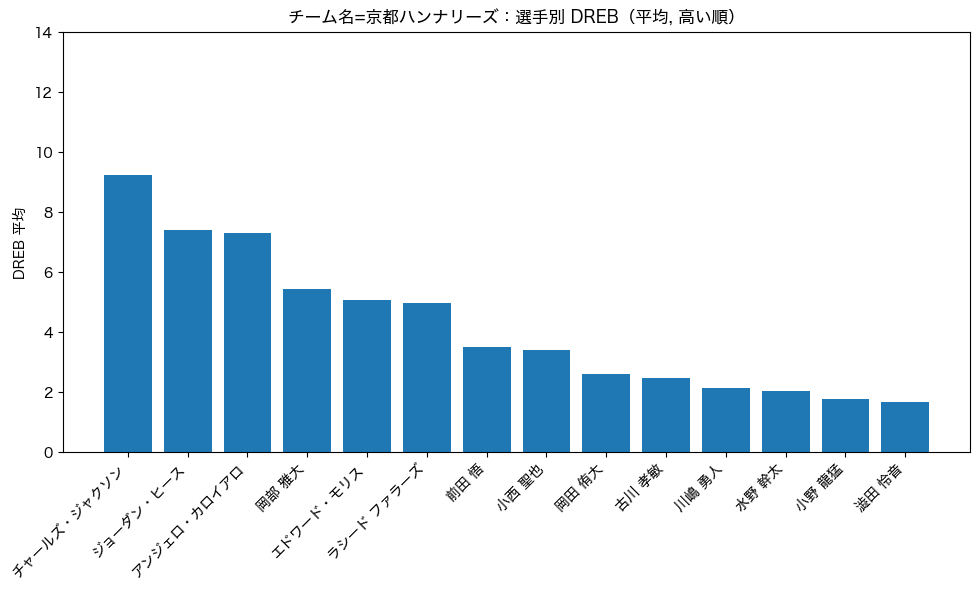

In [ ]:
# DRB 分析（改善版）
team_id = 699  # 必要に応じてチームIDを変更

# df_box が存在するか確認
if 'df_box' not in globals():
    raise RuntimeError("df_box が定義されていません。先にデータ読み込みセルを実行してください。")

# 選手別データ（プレイヤーレベル）を作成
df_players = df_box24_25.loc[df_box24_25['チームID'] == team_id].copy()

# 数値化・欠損処理
df_players['ディフェンスリバウンド'] = pd.to_numeric(df_players['ディフェンスリバウンド'], errors='coerce').fillna(0)

df_players['DREB_per_game'] = df_players['ディフェンスリバウンド'] / df_players['プレイタイム_秒'] * 60 * 40

# 選手ごとに集計
df_dreb_stats = (
    df_players.groupby('選手名')['DREB_per_game']
    .agg(['mean', 'var', 'sum', 'count'])
    .reset_index()
    .rename(columns={'mean': '平均', 'var': '分散', 'sum': '合計', 'count': '試合数'})
)

# チーム内合計が0の場合のガード
total_dreb = df_dreb_stats['合計'].sum()

# ジニ係数（安定化）
def gini(x):
    x = np.array(x, dtype=float)
    if x.size == 0:
        return np.nan
    s = x.sum()
    if s == 0:
        return 0.0
    x = np.sort(x)
    n = x.size
    index = np.arange(1, n + 1)
    return (2.0 * np.sum(index * x) / (n * s) - (n + 1) / n)

gini_dreb = gini(df_dreb_stats['平均'].values)
print(f"DREB のジニ係数（偏り度）: {gini_dreb:.3f}")

# 可視化：選手を合計でソートして表示
df_dreb_stats = df_dreb_stats.sort_values('合計', ascending=False).reset_index(drop=True)
df_dreb_stats['チーム内割合'] = df_dreb_stats['合計'] / total_dreb

display(df_dreb_stats)
team_name_series = df_team.loc[df_team['チームID'] == team_id, 'チーム名'] if 'df_team' in globals() else pd.Series(dtype=object)
team_name = team_name_series.iloc[0].strip() if not team_name_series.empty else None

df_plot = df_dreb_stats.sort_values('平均', ascending=False).reset_index(drop=True)
plt.figure(figsize=(10,6))
plt.bar(df_plot['選手名'], df_plot['平均'])
plt.title(f'チーム名={team_name}：選手別 DREB（平均, 高い順）')
plt.ylabel('DREB 平均')
plt.ylim(0, 14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

DREB のジニ係数（偏り度）: 0.412


,選手名,平均,分散,合計,試合数,チーム内割合
0,ザイラン・チータム,8.163305,38.947585,2489.808143,305,0.195158
1,ルーク・メイ,8.587527,59.632648,2061.006552,240,0.161547
2,スコット・エサトン,6.786977,29.192905,1723.892141,254,0.135123
3,アイザイア・マーフィー,4.194024,28.770981,1161.744514,277,0.091061
4,中東 泰斗,3.209034,21.548456,917.783754,286,0.071938
5,今村 佳太,3.097993,16.155675,762.106164,246,0.059736
6,佐藤 卓磨,2.592651,25.922567,746.683462,288,0.058527
7,張本 天傑,3.276844,41.843222,675.029921,206,0.052911
8,坂本 聖芽,2.729545,24.703908,614.147676,225,0.048139
9,齋藤 拓実,2.229131,13.419150,561.741058,252,0.044031


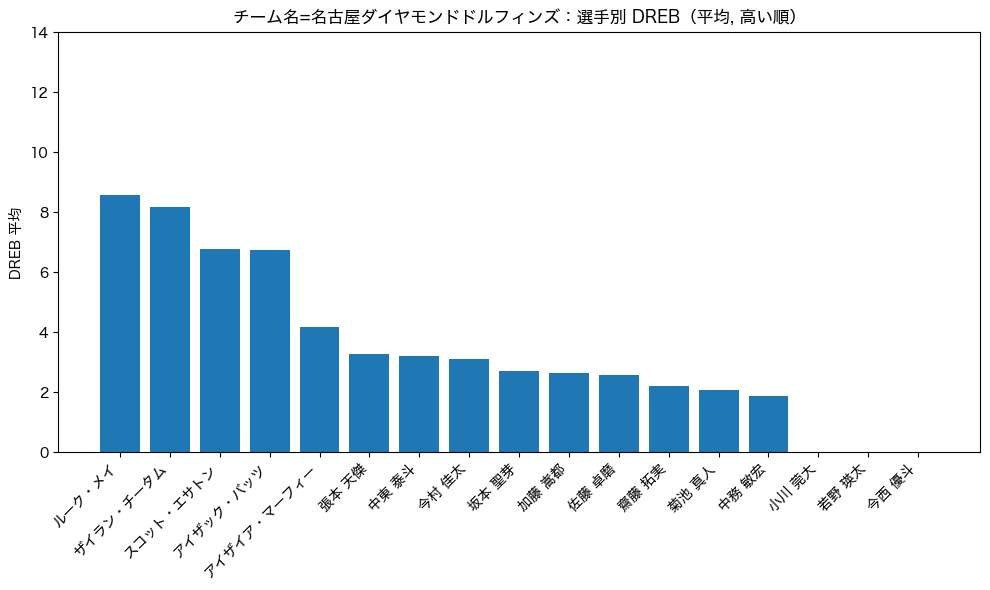

In [ ]:
# DRB 分析（改善版）
team_id = 729  # 必要に応じてチームIDを変更

# df_box が存在するか確認
if 'df_box' not in globals():
    raise RuntimeError("df_box が定義されていません。先にデータ読み込みセルを実行してください。")

# 選手別データ（プレイヤーレベル）を作成
df_players = df_box24_25.loc[df_box24_25['チームID'] == team_id].copy()

# 数値化・欠損処理
df_players['ディフェンスリバウンド'] = pd.to_numeric(df_players['ディフェンスリバウンド'], errors='coerce').fillna(0)

df_players['DREB_per_game'] = df_players['ディフェンスリバウンド'] / df_players['プレイタイム_秒'] * 60 * 40

# 選手ごとに集計
df_dreb_stats = (
    df_players.groupby('選手名')['DREB_per_game']
    .agg(['mean', 'var', 'sum', 'count'])
    .reset_index()
    .rename(columns={'mean': '平均', 'var': '分散', 'sum': '合計', 'count': '試合数'})
)

# チーム内合計が0の場合のガード
total_dreb = df_dreb_stats['合計'].sum()

# ジニ係数（安定化）
def gini(x):
    x = np.array(x, dtype=float)
    if x.size == 0:
        return np.nan
    s = x.sum()
    if s == 0:
        return 0.0
    x = np.sort(x)
    n = x.size
    index = np.arange(1, n + 1)
    return (2.0 * np.sum(index * x) / (n * s) - (n + 1) / n)

gini_dreb = gini(df_dreb_stats['平均'].values)
print(f"DREB のジニ係数（偏り度）: {gini_dreb:.3f}")

# 可視化：選手を合計でソートして表示
df_dreb_stats = df_dreb_stats.sort_values('合計', ascending=False).reset_index(drop=True)
df_dreb_stats['チーム内割合'] = df_dreb_stats['合計'] / total_dreb

display(df_dreb_stats)
team_name_series = df_team.loc[df_team['チームID'] == team_id, 'チーム名'] if 'df_team' in globals() else pd.Series(dtype=object)
team_name = team_name_series.iloc[0].strip() if not team_name_series.empty else None

df_plot = df_dreb_stats.sort_values('平均', ascending=False).reset_index(drop=True)
plt.figure(figsize=(10,6))
plt.bar(df_plot['選手名'], df_plot['平均'])
plt.title(f'チーム名={team_name}：選手別 DREB（平均, 高い順）')
plt.ylabel('DREB 平均')
plt.ylim(0, 14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

DREB のジニ係数（偏り度）: 0.299


,選手名,平均,分散,合計,試合数,チーム内割合
0,ジェームズ・マイケル・マカドゥ,9.925258,52.061515,2967.652227,299,0.243842
1,エヴァンス ルーク,6.263603,31.125141,1841.499359,294,0.151310
2,ニック・ケイ,5.702609,26.611097,1744.998206,306,0.143380
3,コティ・クラーク,6.096585,30.972763,1274.186343,209,0.104695
4,安藤 誓哉,2.616879,10.650174,798.148190,305,0.065581
5,晴山 ケビン,3.183212,50.325030,767.154139,241,0.063034
6,北川 弘,2.819926,36.812284,704.981621,250,0.057926
7,津山 尚大,2.000854,9.157834,570.243248,285,0.046855
8,ワイリー 光希スカイ,3.417784,53.055398,498.996518,146,0.041001
9,アレックス・マーフィー,5.994570,44.776231,419.619891,70,0.034479


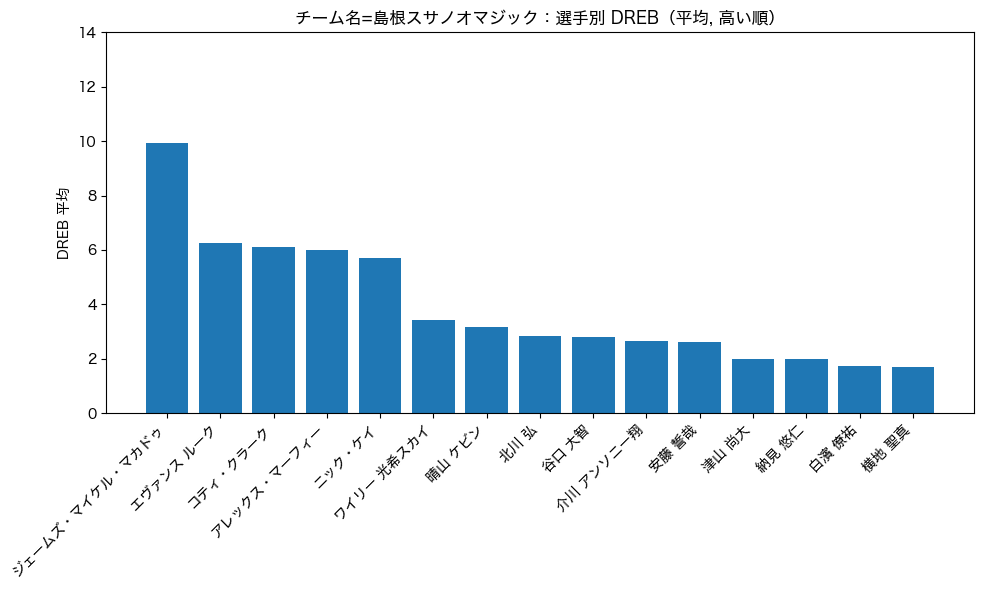

In [ ]:
# DRB 分析（改善版）
team_id = 720  # 必要に応じてチームIDを変更

# df_box が存在するか確認
if 'df_box' not in globals():
    raise RuntimeError("df_box が定義されていません。先にデータ読み込みセルを実行してください。")

# 選手別データ（プレイヤーレベル）を作成
df_players = df_box24_25.loc[df_box24_25['チームID'] == team_id].copy()

# 数値化・欠損処理
df_players['ディフェンスリバウンド'] = pd.to_numeric(df_players['ディフェンスリバウンド'], errors='coerce').fillna(0)

df_players['DREB_per_game'] = df_players['ディフェンスリバウンド'] / df_players['プレイタイム_秒'] * 60 * 40

# 選手ごとに集計
df_dreb_stats = (
    df_players.groupby('選手名')['DREB_per_game']
    .agg(['mean', 'var', 'sum', 'count'])
    .reset_index()
    .rename(columns={'mean': '平均', 'var': '分散', 'sum': '合計', 'count': '試合数'})
)

# チーム内合計が0の場合のガード
total_dreb = df_dreb_stats['合計'].sum()

# ジニ係数（安定化）
def gini(x):
    x = np.array(x, dtype=float)
    if x.size == 0:
        return np.nan
    s = x.sum()
    if s == 0:
        return 0.0
    x = np.sort(x)
    n = x.size
    index = np.arange(1, n + 1)
    return (2.0 * np.sum(index * x) / (n * s) - (n + 1) / n)

gini_dreb = gini(df_dreb_stats['平均'].values)
print(f"DREB のジニ係数（偏り度）: {gini_dreb:.3f}")

# 可視化：選手を合計でソートして表示
df_dreb_stats = df_dreb_stats.sort_values('合計', ascending=False).reset_index(drop=True)
df_dreb_stats['チーム内割合'] = df_dreb_stats['合計'] / total_dreb

display(df_dreb_stats)
team_name_series = df_team.loc[df_team['チームID'] == team_id, 'チーム名'] if 'df_team' in globals() else pd.Series(dtype=object)
team_name = team_name_series.iloc[0].strip() if not team_name_series.empty else None

df_plot = df_dreb_stats.sort_values('平均', ascending=False).reset_index(drop=True)
plt.figure(figsize=(10,6))
plt.bar(df_plot['選手名'], df_plot['平均'])
plt.title(f'チーム名={team_name}：選手別 DREB（平均, 高い順）')
plt.ylabel('DREB 平均')
plt.ylim(0, 14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

DREB のジニ係数（偏り度）: 0.340


,選手名,平均,分散,合計,試合数,チーム内割合
0,ヴィック・ロー,10.129686,41.791662,2826.182443,279,0.202117
1,ジャック・クーリー,8.682000,52.237357,2587.235990,298,0.185029
2,ケヴェ・アルマ,7.253041,52.461357,2009.092251,277,0.143682
3,アレックス・カーク,5.909972,38.803337,1725.711710,292,0.123416
4,脇 真大,3.613662,28.070065,1051.575690,291,0.075205
5,荒川 颯,2.606955,26.903903,724.733362,278,0.051830
6,松脇 圭志,2.997875,22.308397,716.492085,239,0.051241
7,伊藤 達哉,3.511463,47.204188,660.155081,188,0.047212
8,岸本 隆一,2.430807,11.654363,578.532026,238,0.041374
9,小野寺 祥太,1.938616,16.786288,521.487645,269,0.037295


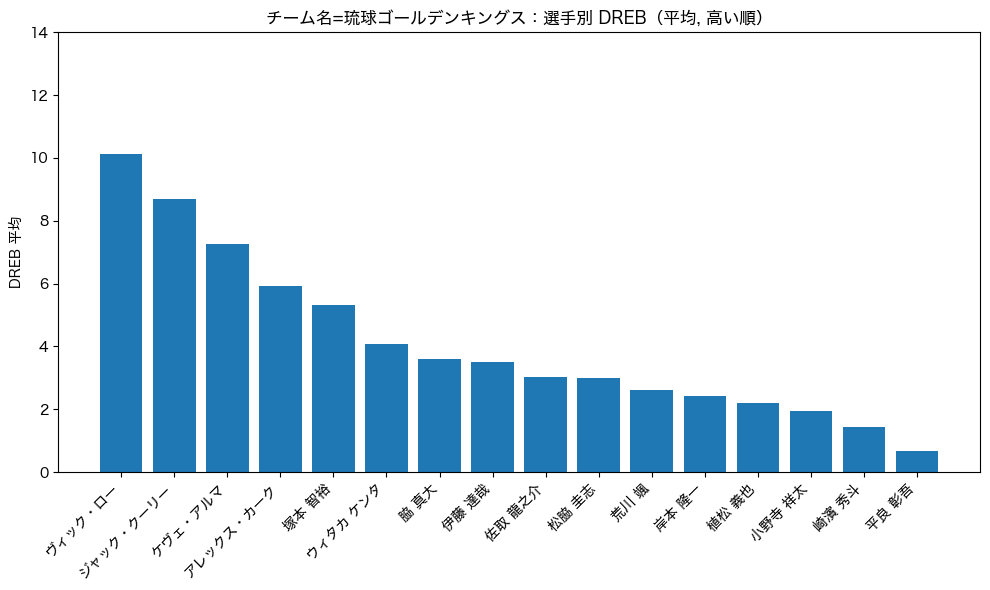

In [ ]:
# DRB 分析（改善版）
team_id = 701  # 必要に応じてチームIDを変更

# df_box が存在するか確認
if 'df_box' not in globals():
    raise RuntimeError("df_box が定義されていません。先にデータ読み込みセルを実行してください。")

# 選手別データ（プレイヤーレベル）を作成
df_players = df_box24_25.loc[df_box24_25['チームID'] == team_id].copy()

# 数値化・欠損処理
df_players['ディフェンスリバウンド'] = pd.to_numeric(df_players['ディフェンスリバウンド'], errors='coerce').fillna(0)

df_players['DREB_per_game'] = df_players['ディフェンスリバウンド'] / df_players['プレイタイム_秒'] * 60 * 40

# 選手ごとに集計
df_dreb_stats = (
    df_players.groupby('選手名')['DREB_per_game']
    .agg(['mean', 'var', 'sum', 'count'])
    .reset_index()
    .rename(columns={'mean': '平均', 'var': '分散', 'sum': '合計', 'count': '試合数'})
)

# チーム内合計が0の場合のガード
total_dreb = df_dreb_stats['合計'].sum()

# ジニ係数（安定化）
def gini(x):
    x = np.array(x, dtype=float)
    if x.size == 0:
        return np.nan
    s = x.sum()
    if s == 0:
        return 0.0
    x = np.sort(x)
    n = x.size
    index = np.arange(1, n + 1)
    return (2.0 * np.sum(index * x) / (n * s) - (n + 1) / n)

gini_dreb = gini(df_dreb_stats['平均'].values)
print(f"DREB のジニ係数（偏り度）: {gini_dreb:.3f}")

# 可視化：選手を合計でソートして表示
df_dreb_stats = df_dreb_stats.sort_values('合計', ascending=False).reset_index(drop=True)
df_dreb_stats['チーム内割合'] = df_dreb_stats['合計'] / total_dreb

display(df_dreb_stats)
team_name_series = df_team.loc[df_team['チームID'] == team_id, 'チーム名'] if 'df_team' in globals() else pd.Series(dtype=object)
team_name = team_name_series.iloc[0].strip() if not team_name_series.empty else None

df_plot = df_dreb_stats.sort_values('平均', ascending=False).reset_index(drop=True)
plt.figure(figsize=(10,6))
plt.bar(df_plot['選手名'], df_plot['平均'])
plt.title(f'チーム名={team_name}：選手別 DREB（平均, 高い順）')
plt.ylabel('DREB 平均')
plt.ylim(0, 14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

DREB のジニ係数（偏り度）: 0.359


,選手名,平均,分散,合計,試合数,チーム内割合
0,ケーレブ・ターズースキー,7.336368,36.911334,2200.910376,300,0.181636
1,ヨハネス・ティーマン,8.189525,51.102000,2014.623087,246,0.166262
2,マイケル・パーカー,6.257505,39.257324,1739.586318,278,0.143564
3,トレイ・ジョーンズ,4.744677,28.183566,1266.828732,267,0.104548
4,コー・フリッピン,4.352167,53.915043,1244.719792,286,0.102724
5,藤井 祐眞,2.793885,16.469905,838.165528,300,0.069172
6,細川 一輝,2.541231,16.876690,719.168239,283,0.059351
7,八村 阿蓮,2.491722,24.494000,637.880711,256,0.052643
8,野本 建吾,4.532211,130.340218,580.122977,128,0.047876
9,辻 直人,1.877840,12.701766,544.573551,290,0.044942


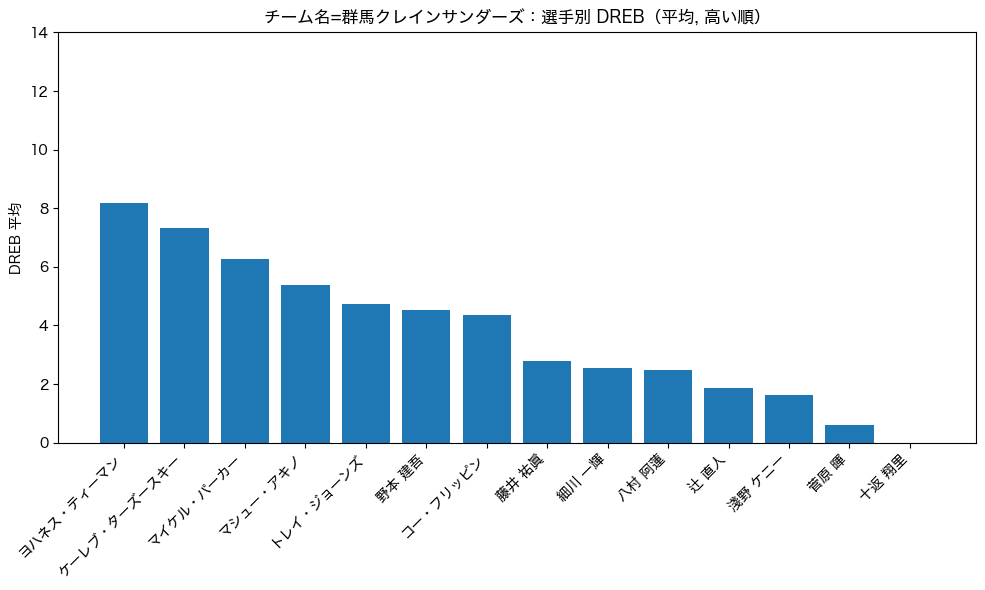

In [ ]:
# DRB 分析（改善版）
team_id = 713  # 必要に応じてチームIDを変更

# df_box が存在するか確認
if 'df_box' not in globals():
    raise RuntimeError("df_box が定義されていません。先にデータ読み込みセルを実行してください。")

# 選手別データ（プレイヤーレベル）を作成
df_players = df_box24_25.loc[df_box24_25['チームID'] == team_id].copy()

# 数値化・欠損処理
df_players['プレイタイム_秒'] = pd.to_numeric(df_players.get('プレイタイム_秒', df_players.get('プレイタイム', None)), errors='coerce')
df_players.loc[df_players['プレイタイム_秒'] <= 0, 'プレイタイム_秒'] = np.nan
df_players['ディフェンスリバウンド'] = pd.to_numeric(df_players['ディフェンスリバウンド'], errors='coerce').fillna(0)
df_players['DREB_per_game'] = df_players['ディフェンスリバウンド'] / df_players['プレイタイム_秒'] * 60 * 40

# 選手ごとに集計
df_dreb_stats = (
    df_players.groupby('選手名')['DREB_per_game']
    .agg(['mean', 'var', 'sum', 'count'])
    .reset_index()
    .rename(columns={'mean': '平均', 'var': '分散', 'sum': '合計', 'count': '試合数'})
)

# チーム内合計が0の場合のガード
total_dreb = df_dreb_stats['合計'].sum()

# ジニ係数（安定化）
def gini(x):
    x = np.asarray(x, dtype=float)
    x = x[~np.isnan(x)]
    if x.size == 0:
        return np.nan
    s = x.sum()
    if s == 0:
        return 0.0
    x = np.sort(x)
    n = x.size
    index = np.arange(1, n + 1)
    return (2.0 * np.sum(index * x) / (n * s) - (n + 1) / n)

gini_dreb = gini(df_dreb_stats['平均'].values)
print(f"DREB のジニ係数（偏り度）: {gini_dreb:.3f}")

# 可視化：選手を合計でソートして表示
df_dreb_stats = df_dreb_stats.sort_values('合計', ascending=False).reset_index(drop=True)
df_dreb_stats['チーム内割合'] = df_dreb_stats['合計'] / total_dreb

display(df_dreb_stats)
team_name_series = df_team.loc[df_team['チームID'] == team_id, 'チーム名'] if 'df_team' in globals() else pd.Series(dtype=object)
team_name = team_name_series.iloc[0].strip() if not team_name_series.empty else None

df_plot = df_dreb_stats.sort_values('平均', ascending=False).reset_index(drop=True)
plt.figure(figsize=(10,6))
plt.bar(df_plot['選手名'], df_plot['平均'])
plt.title(f'チーム名={team_name}：選手別 DREB（平均, 高い順）')
plt.ylabel('DREB 平均')
plt.ylim(0, 14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
top_teamid = [697, 699, 701, 703, 704, 706, 713, 720, 726, 728, 729, 745]

results = []
for i in top_teamid:
    df_box_alphas = df_box_gameid_sum.loc[df_box_gameid_sum['チームID'] == i].copy()
    dreb_win = pd.to_numeric(df_box_alphas.loc[df_box_alphas['勝敗'] == 1, 'ディフェンスリバウンド'], errors='coerce').dropna()
    dreb_lose = pd.to_numeric(df_box_alphas.loc[df_box_alphas['勝敗'] == 0, 'ディフェンスリバウンド'], errors='coerce').dropna()

    n_win = len(dreb_win)
    n_lose = len(dreb_lose)
    mean_win = dreb_win.mean() if n_win > 0 else np.nan
    mean_lose = dreb_lose.mean() if n_lose > 0 else np.nan
    median_win = dreb_win.median() if n_win > 0 else np.nan
    median_lose = dreb_lose.median() if n_lose > 0 else np.nan

    if n_win == 0 or n_lose == 0:
        u_stat = np.nan
        p_value = np.nan
    else:
        try:
            u_stat, p_value = stats.mannwhitneyu(dreb_win, dreb_lose, alternative='two-sided')
        except Exception:
            u_stat = np.nan
            p_value = np.nan

    team_name_series = df_team.loc[df_team['チームID'] == i, 'チーム名']
    team_name = team_name_series.iloc[0].strip() if not team_name_series.empty else None

    results.append({
        'チームID': i,
        'チーム名': team_name,
        'n_win': n_win,
        'n_lose': n_lose,
        'mean_win': mean_win,
        'mean_lose': mean_lose,
        'median_win': median_win,
        'median_lose': median_lose,
        'U統計量': u_stat,
        'p値': p_value
    })

df_results = pd.DataFrame(results)
df_results = df_results[['チーム名','U統計量','p値']]
display(df_results)
df_results.to_csv('dreb_mannwhitneyu_results.csv', index=False, encoding='utf-8-sig')

,チーム名,U統計量,p値
0,三遠ネオフェニックス,378.5,0.069838
1,京都ハンナリーズ,706.5,0.000104
2,琉球ゴールデンキングス,432.5,0.053780
3,宇都宮ブレックス,368.5,0.137952
4,千葉ジェッツ,377.0,0.993532
5,アルバルク東京,462.5,0.065056
6,群馬クレインサンダーズ,568.5,0.013465
7,島根スサノオマジック,586.0,0.014675
8,サンロッカーズ渋谷,712.0,0.000104
9,シーホース三河,713.5,0.000002


In [ ]:
# ...existing code...
top_teamid = [697, 699, 701, 703, 704, 706, 713, 720, 726, 728, 729, 745]

results = []
for i in top_teamid:
    df_box_alphas = df_box_gameid_sum.loc[df_box_gameid_sum['チームID'] == i].copy()
    dreb_win = pd.to_numeric(df_box_alphas.loc[df_box_alphas['勝敗'] == 1, 'ディフェンスリバウンド'], errors='coerce').dropna()
    dreb_lose = pd.to_numeric(df_box_alphas.loc[df_box_alphas['勝敗'] == 0, 'ディフェンスリバウンド'], errors='coerce').dropna()

    n_win = len(dreb_win)
    n_lose = len(dreb_lose)
    mean_win = dreb_win.mean() if n_win > 0 else np.nan
    mean_lose = dreb_lose.mean() if n_lose > 0 else np.nan
    median_win = dreb_win.median() if n_win > 0 else np.nan
    median_lose = dreb_lose.median() if n_lose > 0 else np.nan

    u_stat = np.nan
    p_value = np.nan
    z_stat = np.nan
    r_effect = np.nan
    r_abs = np.nan
    r_interpret = None

    if n_win > 0 and n_lose > 0:
        try:
            u_stat, p_value = stats.mannwhitneyu(dreb_win, dreb_lose, alternative='two-sided')

            # Z の近似（結び目/ties 補正を含む）
            N = n_win + n_lose
            mu_u = n_win * n_lose / 2.0

            # ties 補正項 T = sum(t_j^3 - t_j) / (N*(N-1))
            combined = np.concatenate([dreb_win.values, dreb_lose.values])
            _, counts = np.unique(combined, return_counts=True)
            ties = counts[counts > 1]
            if ties.size > 0:
                T = np.sum(ties * (ties**2 - 1)) / (N * (N - 1))
            else:
                T = 0.0

            var_u = n_win * n_lose * (N + 1 - T) / 12.0
            sd_u = np.sqrt(var_u) if var_u > 0 else np.nan

            if not np.isnan(sd_u) and sd_u > 0:
                z_stat = (u_stat - mu_u) / sd_u
                r_effect = z_stat / np.sqrt(N)
                r_abs = abs(r_effect)
                # 簡易解釈（Cohen の基準に類似）
                if r_abs < 0.1:
                    r_interpret = 'negligible'
                elif r_abs < 0.3:
                    r_interpret = 'small'
                elif r_abs < 0.5:
                    r_interpret = 'medium'
                else:
                    r_interpret = 'large'
        except Exception:
            u_stat = np.nan
            p_value = np.nan
            z_stat = np.nan
            r_effect = np.nan
            r_abs = np.nan
            r_interpret = None

    team_name_series = df_team.loc[df_team['チームID'] == i, 'チーム名']
    team_name = team_name_series.iloc[0].strip() if not team_name_series.empty else None

    results.append({
        'チームID': i,
        'チーム名': team_name,
        'n_win': n_win,
        'n_lose': n_lose,
        'mean_win': mean_win,
        'mean_lose': mean_lose,
        'median_win': median_win,
        'median_lose': median_lose,
        'U統計量': u_stat,
        'p値': p_value,
        'Z値': z_stat,
        '効果量_r': r_effect,
        '効果量_abs': r_abs,
        '効果量解釈': r_interpret
    })

df_results = pd.DataFrame(results)
display(df_results)
# ...existing code...
# filepath: /Users/nakamurawataru/Documents/学校/研究室/SDSC/analysis/DRB.ipynb
# ...existing code...
top_teamid = [697, 699, 701, 703, 704, 706, 713, 720, 726, 728, 729, 745]

results = []
for i in top_teamid:
    df_box_alphas = df_box_gameid_sum.loc[df_box_gameid_sum['チームID'] == i].copy()
    dreb_win = pd.to_numeric(df_box_alphas.loc[df_box_alphas['勝敗'] == 1, 'ディフェンスリバウンド'], errors='coerce').dropna()
    dreb_lose = pd.to_numeric(df_box_alphas.loc[df_box_alphas['勝敗'] == 0, 'ディフェンスリバウンド'], errors='coerce').dropna()

    n_win = len(dreb_win)
    n_lose = len(dreb_lose)
    mean_win = dreb_win.mean() if n_win > 0 else np.nan
    mean_lose = dreb_lose.mean() if n_lose > 0 else np.nan
    median_win = dreb_win.median() if n_win > 0 else np.nan
    median_lose = dreb_lose.median() if n_lose > 0 else np.nan

    u_stat = np.nan
    p_value = np.nan
    z_stat = np.nan
    r_effect = np.nan
    r_abs = np.nan
    r_interpret = None

    if n_win > 0 and n_lose > 0:
        try:
            u_stat, p_value = stats.mannwhitneyu(dreb_win, dreb_lose, alternative='two-sided')

            # Z の近似（結び目/ties 補正を含む）
            N = n_win + n_lose
            mu_u = n_win * n_lose / 2.0

            # ties 補正項 T = sum(t_j^3 - t_j) / (N*(N-1))
            combined = np.concatenate([dreb_win.values, dreb_lose.values])
            _, counts = np.unique(combined, return_counts=True)
            ties = counts[counts > 1]
            if ties.size > 0:
                T = np.sum(ties * (ties**2 - 1)) / (N * (N - 1))
            else:
                T = 0.0

            var_u = n_win * n_lose * (N + 1 - T) / 12.0
            sd_u = np.sqrt(var_u) if var_u > 0 else np.nan

            if not np.isnan(sd_u) and sd_u > 0:
                z_stat = (u_stat - mu_u) / sd_u
                r_effect = z_stat / np.sqrt(N)
                r_abs = abs(r_effect)
                # 簡易解釈（Cohen の基準に類似）
                if r_abs < 0.1:
                    r_interpret = 'negligible'
                elif r_abs < 0.3:
                    r_interpret = 'small'
                elif r_abs < 0.5:
                    r_interpret = 'medium'
                else:
                    r_interpret = 'large'
        except Exception:
            u_stat = np.nan
            p_value = np.nan
            z_stat = np.nan
            r_effect = np.nan
            r_abs = np.nan
            r_interpret = None

    team_name_series = df_team.loc[df_team['チームID'] == i, 'チーム名']
    team_name = team_name_series.iloc[0].strip() if not team_name_series.empty else None

    results.append({
        'チームID': i,
        'チーム名': team_name,
        'n_win': n_win,
        'n_lose': n_lose,
        'mean_win': mean_win,
        'mean_lose': mean_lose,
        'median_win': median_win,
        'median_lose': median_lose,
        'U統計量': u_stat,
        'p値': p_value,
        'Z値': z_stat,
        '効果量_r': r_effect,
        '効果量_abs': r_abs,
        '効果量解釈': r_interpret
    })

df_results = pd.DataFrame(results)
display(df_results)
# ...existing code...

,チームID,チーム名,n_win,n_lose,mean_win,mean_lose,median_win,median_lose,U統計量,p値,Z値,効果量_r,効果量_abs,効果量解釈
0,697,三遠ネオフェニックス,47,12,24.212766,21.333333,24.0,21.0,378.5,0.069838,1.822400,0.237256,0.237256,small
1,699,京都ハンナリーズ,33,27,26.151515,21.222222,26.0,21.0,706.5,0.000104,3.888181,0.501962,0.501962,large
2,701,琉球ゴールデンキングス,46,14,27.152174,23.642857,27.0,25.0,432.5,0.053780,1.937372,0.250114,0.250114,small
3,703,宇都宮ブレックス,48,12,24.979167,23.083333,24.5,22.0,368.5,0.137952,1.492731,0.192711,0.192711,small
4,704,千葉ジェッツ,42,18,25.619048,25.666667,25.0,25.5,377.0,0.993532,-0.016214,-0.002093,0.002093,negligible
5,706,アルバルク東京,44,16,25.386364,23.125000,26.0,23.0,462.5,0.065056,1.853260,0.239255,0.239255,small
6,713,群馬クレインサンダーズ,39,21,23.461538,20.571429,23.0,22.0,568.5,0.013465,2.479012,0.320039,0.320039,medium
7,720,島根スサノオマジック,37,23,25.891892,23.434783,26.0,22.0,586.0,0.014675,2.447923,0.316026,0.316026,medium
8,726,サンロッカーズ渋谷,30,30,25.533333,21.366667,25.0,21.5,712.0,0.000104,3.889438,0.502124,0.502124,large
9,728,シーホース三河,39,21,26.153846,20.000000,26.0,21.0,713.5,0.000002,4.722581,0.609683,0.609683,large


,チームID,チーム名,n_win,n_lose,mean_win,mean_lose,median_win,median_lose,U統計量,p値,Z値,効果量_r,効果量_abs,効果量解釈
0,697,三遠ネオフェニックス,47,12,24.212766,21.333333,24.0,21.0,378.5,0.069838,1.822400,0.237256,0.237256,small
1,699,京都ハンナリーズ,33,27,26.151515,21.222222,26.0,21.0,706.5,0.000104,3.888181,0.501962,0.501962,large
2,701,琉球ゴールデンキングス,46,14,27.152174,23.642857,27.0,25.0,432.5,0.053780,1.937372,0.250114,0.250114,small
3,703,宇都宮ブレックス,48,12,24.979167,23.083333,24.5,22.0,368.5,0.137952,1.492731,0.192711,0.192711,small
4,704,千葉ジェッツ,42,18,25.619048,25.666667,25.0,25.5,377.0,0.993532,-0.016214,-0.002093,0.002093,negligible
5,706,アルバルク東京,44,16,25.386364,23.125000,26.0,23.0,462.5,0.065056,1.853260,0.239255,0.239255,small
6,713,群馬クレインサンダーズ,39,21,23.461538,20.571429,23.0,22.0,568.5,0.013465,2.479012,0.320039,0.320039,medium
7,720,島根スサノオマジック,37,23,25.891892,23.434783,26.0,22.0,586.0,0.014675,2.447923,0.316026,0.316026,medium
8,726,サンロッカーズ渋谷,30,30,25.533333,21.366667,25.0,21.5,712.0,0.000104,3.889438,0.502124,0.502124,large
9,728,シーホース三河,39,21,26.153846,20.000000,26.0,21.0,713.5,0.000002,4.722581,0.609683,0.609683,large


In [10]:
def team_dreb_gini(team_ids=None, by='平均'):
    """
    team_ids: list or array of チームID。None の場合は df_box_gameid_sum に存在する全チーム。
    by: '平均' または '合計' に対してジニを計算。
    """
    if 'df_box_gameid_sum' not in globals():
        raise RuntimeError("df_box_gameid_sum が定義されていません。先に集計セルを実行してください。")

    if team_ids is None:
        team_ids = df_box_gameid_sum['チームID'].unique()

    results = []
    for tid in team_ids:
        # プレイヤーレベルの集計は df_box（個人行）から行う（存在しない場合はゲーム集計を使う）
        df_players = df_box.loc[df_box['チームID'] == tid].copy() if 'df_box' in globals() else pd.DataFrame()

        # プレイタイムを安全に処理
        if not df_players.empty:
            df_players['プレイタイム_秒'] = pd.to_numeric(df_players.get('プレイタイム_秒', df_players.get('プレイタイム', None)), errors='coerce')
            df_players.loc[df_players['プレイタイム_秒'] <= 0, 'プレイタイム_秒'] = np.nan
            df_players['ディフェンスリバウンド'] = pd.to_numeric(df_players.get('ディフェンスリバウンド', 0), errors='coerce').fillna(0)
            df_players['DREB_per_game'] = df_players['ディフェンスリバウンド'] / df_players['プレイタイム_秒'] * 60 * 40
            # プレイヤーごとに集計（試合ごとの行が入っている想定）
            df_dreb_stats = (
                df_players.groupby('選手名')['DREB_per_game']
                .agg(['mean', 'var', 'sum', 'count'])
                .reset_index()
                .rename(columns={'mean': '平均', 'var': '分散', 'sum': '合計', 'count': '試合数'})
            )
        else:
            # 個人データがなければ空の DataFrame を作る
            df_dreb_stats = pd.DataFrame(columns=['選手名','平均','分散','合計','試合数'])

        total_dreb = df_dreb_stats['合計'].sum() if not df_dreb_stats.empty else 0.0
        n_players = len(df_dreb_stats)

        # ジニ関数（NaN を除去し、合計ゼロをガード）
        def gini_arr(arr):
            x = np.asarray(arr, dtype=float)
            x = x[~np.isnan(x)]
            if x.size == 0:
                return np.nan
            s = x.sum()
            if s == 0:
                return 0.0
            x = np.sort(x)
            n = x.size
            idx = np.arange(1, n + 1)
            return (2.0 * np.sum(idx * x) / (n * s) - (n + 1) / n)

        # ジニをどの指標に対して計算するか選択
        if by == '合計':
            gini_value = gini_arr(df_dreb_stats['合計'].values)
        else:
            # デフォルトは '平均'
            gini_value = gini_arr(df_dreb_stats['平均'].values)

        # チーム名取得（存在チェック）
        team_name_series = df_team.loc[df_team['チームID'] == tid, 'チーム名'] if 'df_team' in globals() else pd.Series(dtype=object)
        team_name = team_name_series.iloc[0].strip() if not team_name_series.empty else None

        results.append({
            'チームID': tid,
            'チーム名': team_name,
            '選手数': n_players,
            # 'チーム合計_DREB(合計列の合計)': total_dreb,
            f'ジニ({by})': gini_value
        })

    return pd.DataFrame(results)

# クラスター0のチームIDを取得（list_cluster0から）
if 'list_cluster0' in globals() and 'df_team' in globals():
    # チーム名からチームIDへ変換
    cluster0_team_ids = df_team[df_team['チーム名'].isin(list_cluster0)]['チームID'].tolist()
    # 越谷アルファーズのチームIDを取得
    koshigaya_team_id = df_team[df_team['チーム名'] == '越谷アルファーズ']['チームID'].tolist()
    # 結合してユニークなリストを作成
    team_ids = list(set(cluster0_team_ids + koshigaya_team_id))
else:
    # フォールバック: top_teamid を使用
    team_ids = globals().get('top_teamid', None)

df_team_gini = team_dreb_gini(team_ids=team_ids, by='平均')

# ジニ(平均)で降順に並び替え、小数点2位まで表示
df_display = df_team_gini[['チーム名','ジニ(平均)']].sort_values('ジニ(平均)', ascending=False).reset_index(drop=True)
df_display['ジニ(平均)'] = df_display['ジニ(平均)'].round(2)
display(df_display)

df_team_gini.to_csv('team_dreb_gini.csv', index=False, encoding='utf-8-sig')

,チーム名,ジニ(平均)
0,宇都宮ブレックス,0.39
1,越谷アルファーズ,0.39
2,シーホース三河,0.37
3,名古屋ダイヤモンドドルフィンズ,0.37
4,サンロッカーズ渋谷,0.34
5,群馬クレインサンダーズ,0.33
6,京都ハンナリーズ,0.31
7,琉球ゴールデンキングス,0.30
8,島根スサノオマジック,0.29
9,アルバルク東京,0.28
